In [1]:
import secrets
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
data_path = Path().resolve().parent / "data"

In [3]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)
indices_train = rng.choice(5000, 2500, replace=False)
indices_test = rng.choice(800, 400, replace=False)
flag_full_dataset = False  # If it is True it will use full train and test datasets 

In [4]:
train_list = []  # Auxiliary list of train datasets
for f in data_path.glob("train*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_train, :]  # Sample or full dataset
    target = raw_data[:, [0]]  # Target values, i.e. digit 
    features = (raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)).astype(bool).astype(int)  # Pixels values, normalization and then cast to 0 and 1
    train_list.append(np.hstack((target, features)))  # Add to the temp list
train_data = np.vstack(train_list)  # Concatenate train datasets
train_data.shape

(25000, 785)

In [5]:
# Similar to train dataset
test_list = []
for f in data_path.glob("test*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_test, :]
    target = raw_data[:, [0]]
    features = (raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)).astype(bool).astype(int)
    test_list.append(np.hstack((target, features)))
test_data = np.vstack(test_list)
test_data.shape

(4000, 785)

/tmp/ipykernel_5688/2286281631.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


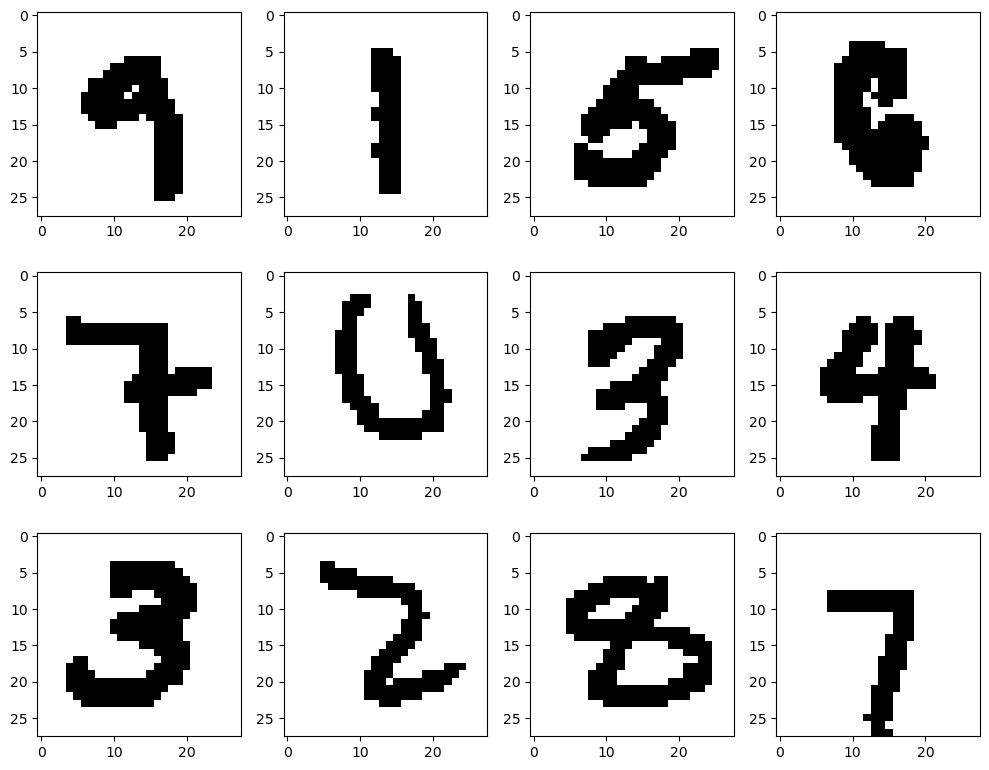

In [6]:
# Show a few examples of images
width, height = 28, 28
img_indices = rng.choice(train_data.shape[0], 12)  # Random samples
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
for i, ax in zip(img_indices, axs.flatten()):
    sample_image = train_data[i, 1:].reshape(width, height)
    ax.imshow(sample_image, cmap=plt.cm.gray_r)
fig.tight_layout()
fig.savefig("minst_examples.png", dpi=300)
fig.show()

In [7]:
# Split datasets into features matrices and target vectors
X_train = train_data[:, 1:]
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)

In [8]:
y_train_unique, y_train_count = np.unique(y_train, return_counts=True)  # Get unique targets values (digits) and its count
prob_v_dict = dict(zip(y_train_unique.astype(int), y_train_count / y_train.size))  # Dictionary with $prob(v_j)$

m = 1
p = 1 / 2  # Values can be 0 or 1

prob_a_0_dict = {}  # Dictionary with $p(a_i | v_j)$ when $a_i$ = 0 for each $v_j$
prob_a_1_dict = {}  # Dictionary with $p(a_i | v_j)$ when $a_i$ = 1 for each $v_j$
for j in y_train_unique:
    X_train_target_j = X_train[y_train == j]
    prob_a_0_dict[j] = ((X_train_target_j == 0).sum(axis=0) + m * p) / (X_train_target_j.shape[0] + m)
    prob_a_1_dict[j] = ((X_train_target_j == 1).sum(axis=0) + m * p) / (X_train_target_j.shape[0] + m)

In [9]:
y_pred = np.empty(shape=X_test.shape[0])  # Vector of predictions
for i in range(X_test.shape[0]):  # Iterate over each sample
    X_test_i = X_test[i, :]
    prob_dict = {}  # Dictionary of $p(a_1, ..., a_n | v_j) p(v_j)$ for each $v_j$
    for j in y_train_unique:
        prob_dict[j] = (
            prob_v_dict[j]
            * np.prod(prob_a_0_dict[j][X_test_i == 0])
            * np.prod(prob_a_1_dict[j][X_test_i == 1])
        )
    y_pred[i] = int(max(prob_dict, key=prob_dict.get))  # Argmax

In [10]:
n = y_pred.size
error_h = sum(y_pred == y_test) / n
sigma = np.sqrt(error_h * (1 - error_h) / n)
print(f"Accuracy was {error_h:.2%} and with approximately 95% probability the true error lies in the interval [{error_h - 1.96 * sigma:.4f}, {error_h + 1.96 * sigma:.4f}]")

Accuracy was 83.45% and with approximately 95% probability the true error lies in the interval [0.8230, 0.8460]


/tmp/ipykernel_5688/210490572.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


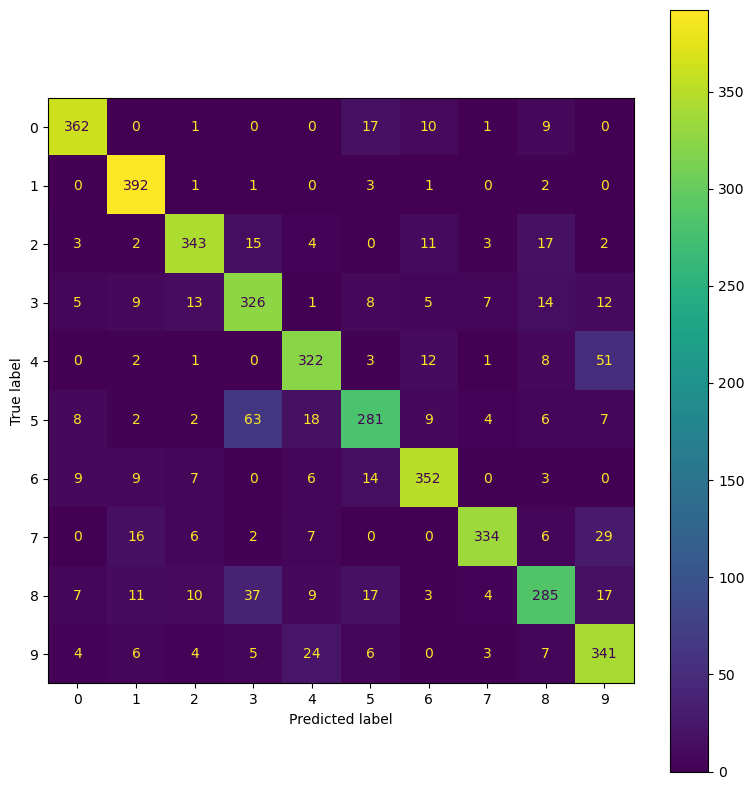

In [11]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax
)
fig.tight_layout()
fig.savefig(f"confusion_matrix_fulldata_{flag_full_dataset}.png", dpi=300)
fig.show()

/tmp/ipykernel_5688/1299476634.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


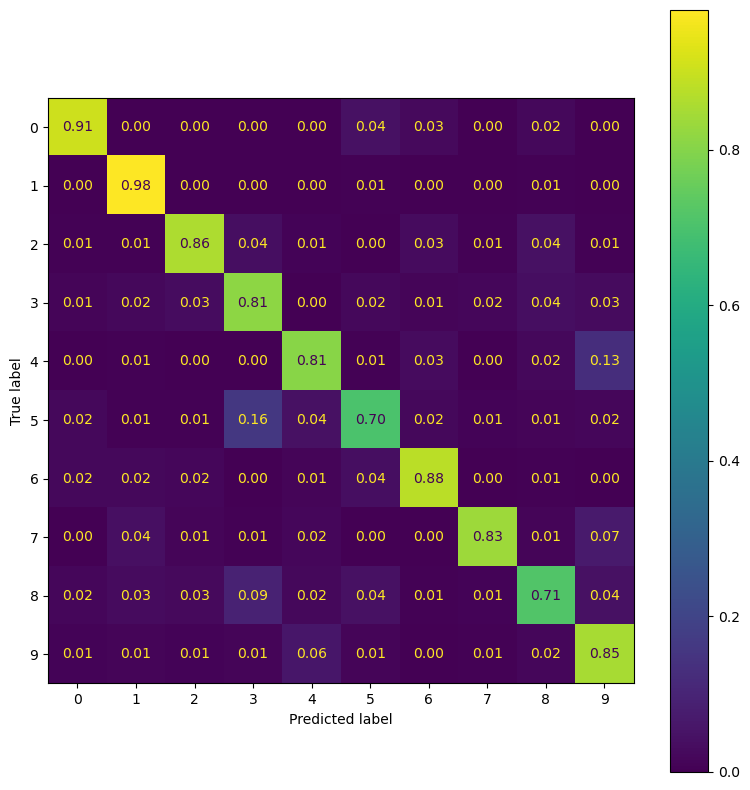

In [12]:
# Confusion matrix - row normalization
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true",
    values_format=".2f",
    ax=ax
)
fig.tight_layout()
fig.savefig(f"confusion_matrix_row_normalize_fulldata_{flag_full_dataset}.png", dpi=300)
fig.show()